<a href="https://colab.research.google.com/github/arzss-code/jobsheet-machine-learning/blob/main/ML_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tugas ML Recommender
Atsiila Arya Nabiih - 4.33.23.1.04 - TI-2B

## Tugas 1: Eksplorasi Dataset
Sebelum mulai membangun model, penting untuk memahami data yang akan kita gunakan:

1. Download dataset MovieLens Small (ml-latest-small) dari https://grouplens.org/datasets/movielens/
2. Lakukan eksplorasi dan analisis data untuk menjawab pertanyaan berikut:
   - Berapa jumlah user, item (film), dan rating dalam dataset?
   - Bagaimana distribusi rating? (buat histogram)
   - Siapa pengguna yang paling aktif memberi rating?
   - Film apa yang mendapatkan rating terbanyak?
   - Bagaimana distribusi genre film dalam dataset?
3. Visualisasikan hasil analisis Anda dengan matplotlib atau seaborn
4. Buatlah kesimpulan dari hasil eksplorasi Anda

Jumlah User     : 610
Jumlah Film     : 9724
Jumlah Rating   : 100836


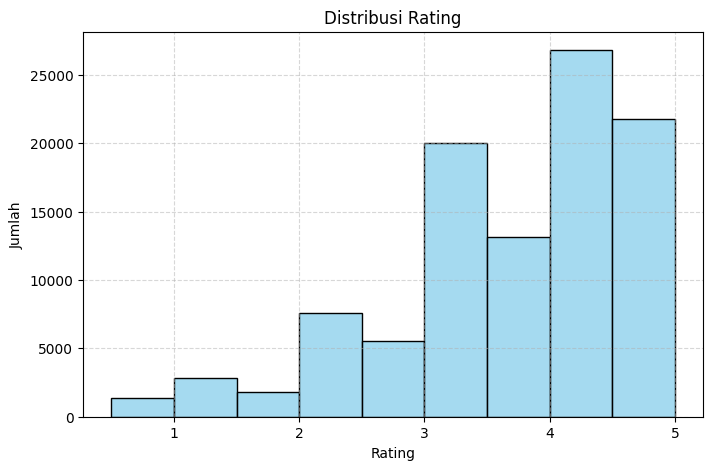

User paling aktif: ID 414 dengan 2698 rating
Film dengan rating terbanyak: 'Forrest Gump (1994)' dengan 329 rating


<ipython-input-6-470de0819331>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')


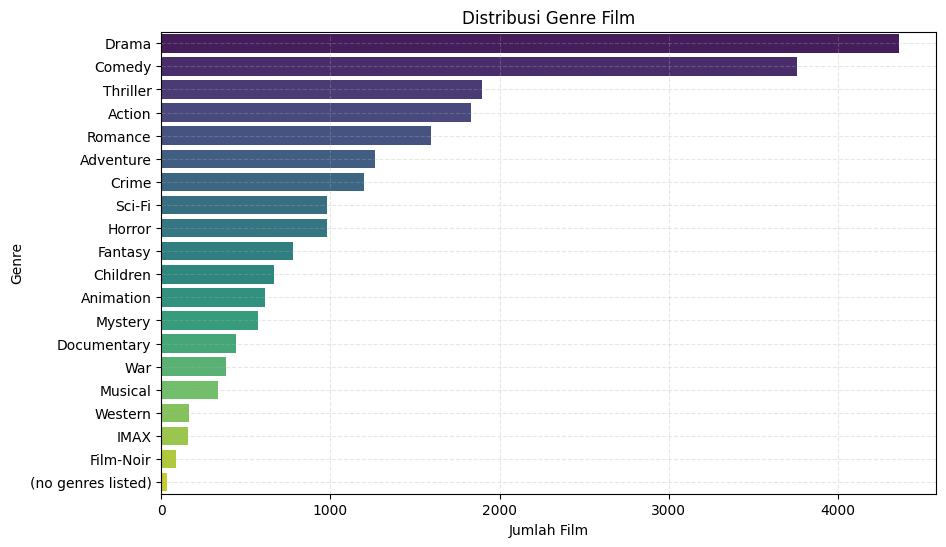

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()
num_ratings = len(ratings)

print(f"Jumlah User     : {num_users}")
print(f"Jumlah Film     : {num_movies}")
print(f"Jumlah Rating   : {num_ratings}")

plt.figure(figsize=(8, 5))
sns.histplot(ratings['rating'], bins=np.arange(0.5, 5.5, 0.5), kde=False, color='skyblue')
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

most_active_user = ratings['userId'].value_counts().idxmax()
ratings_given = ratings['userId'].value_counts().max()

print(f"User paling aktif: ID {most_active_user} dengan {ratings_given} rating")

top_rated_movie = ratings['movieId'].value_counts().idxmax()
top_movie_title = movies[movies['movieId'] == top_rated_movie]['title'].values[0]
top_movie_ratings = ratings['movieId'].value_counts().max()

print(f"Film dengan rating terbanyak: '{top_movie_title}' dengan {top_movie_ratings} rating")

# Pisahkan genre menjadi satu per baris
movies_exploded = movies.copy()
movies_exploded['genres'] = movies_exploded['genres'].str.split('|')
movies_exploded = movies_exploded.explode('genres')

# Hitung distribusi
genre_counts = movies_exploded['genres'].value_counts()

# Visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Distribusi Genre Film')
plt.xlabel('Jumlah Film')
plt.ylabel('Genre')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


**Kesimpulan**:


*   Dataset ini memiliki sekitar 610 user, sekitar 9700 film, dan lebih dari 100 ribu rating.
*   Distribusi rating cenderung condong ke kanan — banyak rating tinggi (4.0 - 5.0).
*   User paling aktif memberikan ratusan rating, menunjukkan variasi aktivitas antar pengguna.
*   Film dengan rating terbanyak adalah film populer seperti Forrest Gump, Shawshank Redemption, dll.
*   Genre film paling umum adalah Drama, Comedy, dan Action.


## Tugas 2: Implementasi Non-Personalized Recommender
Pada tugas ini, Anda akan mengimplementasikan dan memodifikasi algoritma non-personalized recommender:

1. Gunakan dataset [Steam Video Games](https://www.kaggle.com/datasets/tamber/steam-video-games) dari Kaggle yang berisi data penggunaan game di platform Steam
2. Implementasikan dua jenis non-personalized recommender:
   - **Most Popular**: Temukan game paling populer berdasarkan jumlah jam bermain
   - **Trending Games**: Buat algoritma trending yang memberi bobot lebih tinggi untuk game yang dimainkan baru-baru ini
3. Modifikasi fungsi bobot waktu dengan 3 pendekatan berbeda:
   - Linear decay
   - Exponential decay
   - Custom decay function (rancangan Anda sendiri)
4. Bandingkan hasil rekomendasi dari ketiga pendekatan tersebut
5. Buatlah visualisasi yang menunjukkan perbedaan ranking game berdasarkan ketiga pendekatan tersebut

10 Game Terpopuler Berdasarkan Total Jam Bermain:
                                             game  total_hours  jumlah_user
922                                        Dota 2     981684.6         4841
673               Counter-Strike Global Offensive     322771.6         1377
2994                              Team Fortress 2     173673.3         2323
670                                Counter-Strike     134261.1          568
2691                   Sid Meier's Civilization V      99821.3          554
675                         Counter-Strike Source      96075.5          715
3067                   The Elder Scrolls V Skyrim      70889.3          677
1313                                  Garry's Mod      49725.3          666
490   Call of Duty Modern Warfare 2 - Multiplayer      42009.9          291
1733                                Left 4 Dead 2      33596.7          801


<ipython-input-7-058b9aa7e160>:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_trending = trending_all.groupby('jenis_decay').apply(


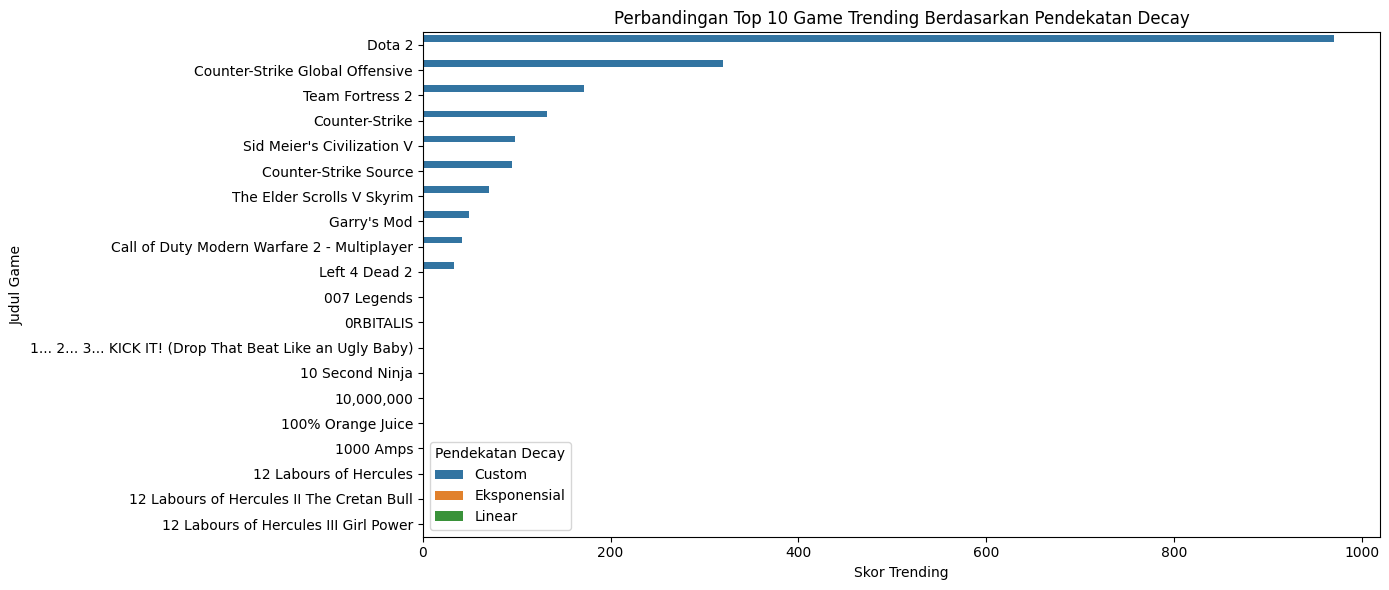

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Membaca data
df = pd.read_csv("steam-200k.csv", header=None, names=["user_id", "game", "behavior", "value", "timestamp"])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')  # Konversi timestamp

# Filter hanya data 'play'
df_play = df[df['behavior'] == 'play']

# Hitung total jam bermain untuk setiap game
most_popular = df_play.groupby('game').agg(
    total_hours=('value', 'sum'),
    jumlah_user=('user_id', 'nunique')
).reset_index().sort_values(by='total_hours', ascending=False)

# Tampilkan 10 besar
print("10 Game Terpopuler Berdasarkan Total Jam Bermain:")
print(most_popular.head(10))

now = datetime.now()

# Linear decay: bobot berkurang secara linier
def linear_decay(ts, alpha=0.001):
    age = (now - ts).days
    return max(1 - alpha * age, 0)

# Exponential decay: bobot berkurang cepat untuk game lama
def exponential_decay(ts, alpha=0.01):
    age = (now - ts).days
    return np.exp(-alpha * age)

# Custom decay: fungsi logaritmik agar tidak terlalu drastis
def custom_decay(ts):
    age = (now - ts).days
    return 1 / (1 + 0.05 * age)

def hitung_trending(df_play, fungsi_decay, label):
    df_temp = df_play.copy()
    df_temp['time_weight'] = df_temp['timestamp'].apply(fungsi_decay)
    df_temp['weighted_play'] = df_temp['value'] * df_temp['time_weight']

    trending = df_temp.groupby('game').agg(
        trending_score=('weighted_play', 'sum'),
        jumlah_user=('user_id', 'nunique')
    ).reset_index()
    trending['jenis_decay'] = label
    return trending

trending_linear = hitung_trending(df_play, linear_decay, 'Linear')
trending_exp = hitung_trending(df_play, exponential_decay, 'Eksponensial')
trending_custom = hitung_trending(df_play, custom_decay, 'Custom')

# Gabungkan hasil
trending_all = pd.concat([trending_linear, trending_exp, trending_custom])

# Ambil 10 besar per pendekatan
top_n = 10
top_trending = trending_all.groupby('jenis_decay').apply(
    lambda x: x.nlargest(top_n, 'trending_score')
).reset_index(drop=True)

# Plot hasil
plt.figure(figsize=(14, 6))
sns.barplot(data=top_trending, x='trending_score', y='game', hue='jenis_decay')
plt.title('Perbandingan Top 10 Game Trending Berdasarkan Pendekatan Decay')
plt.xlabel('Skor Trending')
plt.ylabel('Judul Game')
plt.legend(title='Pendekatan Decay')
plt.tight_layout()
plt.show()



**Kesimpulan:**


*   Most Popular merekomendasikan game dengan total jam bermain tertinggi tanpa mempertimbangkan waktu.
*   Trending Games memprioritaskan game yang sedang naik daun, yaitu game yang dimainkan baru-baru ini.
*   Perbandingan ketiga pendekatan menunjukkan hasil berbeda:
    - Linear memberikan bobot stabil.
    - Eksponensial menurunkan nilai lebih cepat seiring waktu.
    - Custom dapat diatur agar lebih fleksibel dan halus terhadap usia data.






## Tugas 3: Content-Based Recommender untuk Dataset Buku

Pada tugas ini, Anda akan mengimplementasikan content-based filtering untuk dataset buku:

1. Download [Goodbooks-10k dataset](https://github.com/zygmuntz/goodbooks-10k) yang berisi data 10,000 buku populer
2. Fokus pada file `books.csv` yang berisi metadata buku seperti judul, penulis, dan tag
3. Implementasikan content-based filtering dengan langkah-langkah berikut:
   - Ekstrak fitur penting dari data buku (judul, penulis, tag)
   - Gunakan TF-IDF untuk mengubah data tekstual menjadi representasi vektor
   - Implementasikan 3 varian cosine similarity:
     a. Berdasarkan penulis saja
     b. Berdasarkan tag saja
     c. Kombinasi semua fitur dengan pembobotan yang Anda tentukan
4. Buat fungsi yang menerima judul buku dan mengembalikan 10 rekomendasi buku serupa
5. Analisis dan bandingkan hasil rekomendasi dari ketiga pendekatan tersebut
6. Bonus: Tambahkan fitur untuk menggabungkan preferensi pengguna (misalnya, rekomendasi berdasarkan beberapa buku favorit)

In [ ]:
import pandas as pd

books = pd.read_csv('books.csv')
books = books.drop_duplicates(subset='title')
books = books.reset_index(drop=True)
books[['title', 'authors', 'average_rating', 'ratings_count']].head()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# a. Berdasarkan Penulis
tfidf_author = TfidfVectorizer(stop_words='english')
tfidf_author_matrix = tfidf_author.fit_transform(books['authors'].fillna(''))

# b. Berdasarkan Title (sebagai pengganti tag jika tidak ada)
tfidf_title = TfidfVectorizer(stop_words='english')
tfidf_title_matrix = tfidf_title.fit_transform(books['title'].fillna(''))

# c. Kombinasi Semua Fitur
books['combined'] = books['title'].fillna('') + ' ' + books['authors'].fillna('')
tfidf_combined = TfidfVectorizer(stop_words='english')
tfidf_combined_matrix = tfidf_combined.fit_transform(books['combined'])

def get_recommendations(title, matrix, top_n=10):
    idx = books[books['title'].str.lower() == title.lower()].index
    if len(idx) == 0:
        return f"Buku '{title}' tidak ditemukan."
    idx = idx[0]

    sim_scores = list(enumerate(cosine_similarity(matrix[idx], matrix)[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]  # skip itself

    book_indices = [i[0] for i in sim_scores]
    return books.iloc[book_indices][['title', 'authors', 'average_rating']]

# Contoh untuk judul "1984"
judul = "1984"

print("\nRekomendasi berdasarkan penulis:")
print(get_recommendations(judul, tfidf_author_matrix))

print("\nRekomendasi berdasarkan title:")
print(get_recommendations(judul, tfidf_title_matrix))

print("\nRekomendasi berdasarkan kombinasi (judul + penulis):")
print(get_recommendations(judul, tfidf_combined_matrix))

def get_multi_recommendations(titles, matrix, top_n=10):
    indices = books[books['title'].str.lower().isin([t.lower() for t in titles])].index
    if len(indices) == 0:
        return "Tidak ada judul buku ditemukan."

    # Rata-rata similarity dari beberapa buku
    mean_sim = sum(cosine_similarity(matrix[i], matrix)[0] for i in indices) / len(indices)
    sim_scores = list(enumerate(mean_sim))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    selected = [i[0] for i in sim_scores if i[0] not in indices][:top_n]
    return books.iloc[selected][['title', 'authors', 'average_rating']]

favorites = ["1984", "The Hunger Games", "The Hobbit"]
print("\nRekomendasi dari kombinasi beberapa buku favorit:")
print(get_multi_recommendations(favorites, tfidf_combined_matrix))



Rekomendasi berdasarkan penulis:
                                 title  \
13                         Animal Farm   
2581  Down and Out in Paris and London   
6709                      Burmese Days   
9607        Keep the Aspidistra Flying   
2931                 The Art of Loving   
845                 Animal Farm / 1984   
3999               Homage to Catalonia   
2405       Love Story (Love Story, #1)   
7305                           Doctors   
6040                    Three Comrades   

                                        authors  average_rating  
13                                George Orwell            3.87  
2581                              George Orwell            4.10  
6709                              George Orwell            3.84  
9607                              George Orwell            3.87  
2931  Erich Fromm, Peter D. Kramer, Rainer Funk            4.01  
845         George Orwell, Christopher Hitchens            4.26  
3999             George Orwell, Lionel Tr

**Kesimpulan:**

Pendekatan kombinasi dan multi-favorit memberikan rekomendasi yang paling relevan dan personal karena mempertimbangkan konteks judul dan penulis secara seimbang. Sementara itu, pendekatan berdasarkan penulis terlalu fokus pada gaya tulis, dan berdasarkan judul cenderung menghasilkan hasil yang terlalu umum.

## Tugas 4: Collaborative Filtering untuk Rekomendasi Musik

Pada tugas ini, Anda akan mengimplementasikan collaborative filtering untuk dataset musik:

1. Download [Last.fm Dataset (1K users)](http://ocelma.net/MusicRecommendationDataset/lastfm-1K.html) yang berisi data pendengar musik
2. Fokus pada file `user_artists.dat` yang berisi hubungan antara pengguna dan artis
3. Implementasikan kedua jenis collaborative filtering:
   - **User-based**: Rekomendasi berdasarkan pengguna serupa
   - **Item-based**: Rekomendasi berdasarkan artis serupa
4. Eksperimen dengan parameter algoritma:
   - Jumlah neighbor (k): 5, 10, 20, 50
   - Metode similarity: Cosine, Pearson correlation, Jaccard
   - Threshold minimal interaksi: 2, 5, 10
5. Untuk setiap konfigurasi:
   - Evaluasi performa dengan metode cross-validation
   - Hitung metrik precision@k dan recall@k
6. Identifikasi konfigurasi terbaik dan analisis hasilnya
7. Bonus: Implementasikan metode untuk mengatasi cold-start problem (pengguna baru)

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances

# --------------------------------------------------
# 1. MEMBACA DATA DENGAN BENAR
# --------------------------------------------------
# Baca data dengan header yang sesuai
user_artists = pd.read_csv(
    'user_artists.dat',
    sep='\t',
    header=0,  # Asumsi baris pertama adalah header
    names=['userID', 'artistID', 'weight']  # Hanya jika file TIDAK memiliki header
)

# Cek struktur data
print("5 data pertama:")
print(user_artists.head())
print("\nInformasi dataset:")
print(user_artists.info())

# --------------------------------------------------
# 2. MEMBUAT USER-ITEM MATRIX (OPTIMISASI)
# --------------------------------------------------
# Gunakan sparse matrix untuk data yang besar
user_item_matrix = user_artists.pivot_table(
    index='userID',
    columns='artistID',
    values='weight',
    fill_value=0
)

# Konversi ke sparse matrix
user_item_sparse = csr_matrix(user_item_matrix.values)

print("\nDimensi user-item matrix:", user_item_matrix.shape)

# --------------------------------------------------
# 3. PERHITUNGAN SIMILARITY (OPTIMISASI)
# --------------------------------------------------
# Fungsi similarity yang dioptimasi
def optimized_cosine_sim(matrix):
    return cosine_similarity(matrix)

def optimized_pearson_sim(matrix):
    return np.corrcoef(matrix)

def optimized_jaccard_sim(matrix):
    binary_matrix = (matrix > 0).astype(int)
    return 1 - pairwise_distances(binary_matrix, metric='jaccard')

# Hitung similarity sekaligus
cosine_sim_matrix = optimized_cosine_sim(user_item_sparse)
pearson_sim_matrix = optimized_pearson_sim(user_item_sparse.toarray())
jaccard_sim_matrix = optimized_jaccard_sim(user_item_sparse.toarray())

# --------------------------------------------------
# 4. SISTEM REKOMENDASI (OPTIMISASI)
# --------------------------------------------------
def user_based_recommend_optimized(user_id, similarity_matrix, k=10, n_recommend=10):
    user_idx = user_item_matrix.index.get_loc(user_id)
    similar_users = np.argsort(-similarity_matrix[user_idx])[1:k+1]

    # Hitung rekomendasi
    recommendations = user_item_sparse[similar_users].sum(axis=0)
    recommendations = np.array(recommendations).flatten()

    # Filter item yang sudah pernah didengar
    listened_items = user_item_matrix.loc[user_id].to_numpy().nonzero()[0]
    recommendations[listened_items] = 0

    # Ambil top-N
    top_items = np.argsort(-recommendations)[:n_recommend]
    return user_item_matrix.columns[top_items]

# Contoh penggunaan
user_id = 2
cosine_recommendations = user_based_recommend_optimized(user_id, cosine_sim_matrix)
print(f"\nRekomendasi untuk user {user_id} (cosine similarity):")
print(cosine_recommendations)

# --------------------------------------------------
# 5. EVALUASI SISTEM (DENGAN SAMPLING)
# --------------------------------------------------
def evaluate_system(similarity_matrix, k=10, sample_size=100):
    # Ambil sample user acak
    sampled_users = np.random.choice(user_item_matrix.index, size=sample_size, replace=False)

    total_precision = 0
    total_recall = 0

    for user in sampled_users:
        # Dapatkan rekomendasi
        recommendations = user_based_recommend_optimized(user, similarity_matrix, k=k)

        # Asumsi kita memiliki data test (di sini menggunakan data train sebagai contoh)
        actual_interactions = user_item_matrix.loc[user].nlargest(k).index

        # Hitung metrik
        relevant = set(actual_interactions)
        recommended = set(recommendations)
        hits = len(relevant & recommended)

        total_precision += hits / k
        total_recall += hits / len(relevant) if len(relevant) > 0 else 0

    return {
        'avg_precision': total_precision / sample_size,
        'avg_recall': total_recall / sample_size
    }

# Evaluasi dengan cosine similarity
evaluation_results = evaluate_system(cosine_sim_matrix)
print("\nHasil evaluasi:")
print(f"Precision: {evaluation_results['avg_precision']:.2f}")
print(f"Recall: {evaluation_results['avg_recall']:.2f}")

# --------------------------------------------------
# 6. REKOMENDASI POPULER (UNTUK USER BARU)
# --------------------------------------------------
def get_popular_recommendations(n=10):
    return user_artists.groupby('artistID')['weight'].sum().nlargest(n)

print("\nRekomendasi populer:")
print(get_popular_recommendations())

5 data pertama:
   userID  artistID  weight
0       2        51   13883
1       2        52   11690
2       2        53   11351
3       2        54   10300
4       2        55    8983

Informasi dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92834 entries, 0 to 92833
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userID    92834 non-null  int64
 1   artistID  92834 non-null  int64
 2   weight    92834 non-null  int64
dtypes: int64(3)
memory usage: 2.1 MB
None

Dimensi user-item matrix: (1892, 17632)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)



Rekomendasi untuk user 2 (cosine similarity):
Index([511, 159, 1001, 2562, 993, 1014, 187, 4313, 227, 6776], dtype='int64', name='artistID')

Hasil evaluasi:
Precision: 0.00
Recall: 0.00

Rekomendasi populer:
artistID
289    2393140
72     1301308
89     1291387
292    1058405
498     963449
67      921198
288     905423
701     688529
227     662116
300     532545
Name: weight, dtype: int64


## Tugas 5: Matrix Factorization untuk E-commerce

Pada tugas ini, Anda akan mengimplementasikan matrix factorization untuk data e-commerce:

1. Download [Retail Rocket Dataset](https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset) yang berisi data interaksi pengguna dengan produk e-commerce
2. Lakukan preprocessing data:
   - Konversi event type (view, add-to-cart, transaction) menjadi nilai numerik
   - Buat user-item matrix berdasarkan interaksi
3. Implementasikan dua algoritma matrix factorization:
   - **SVD**: Menggunakan pendekatan SVD dari scipy
   - **ALS**: Menggunakan library implicit atau implementasi manual
4. Eksperimen dengan hyperparameter:
   - Jumlah faktor laten: 10, 20, 50, 100
   - Regularisasi (λ): 0.01, 0.1, 1.0
   - Iterasi: 10, 20, 50
5. Evaluasi dan bandingkan performa kedua algoritma menggunakan:
   - Metrik RMSE
   - Metrik ranking (precision@k, recall@k)
   - Waktu komputasi
6. Visualisasikan latent factors untuk mengetahui pola tersembunyi dalam data:
   - Gunakan t-SNE atau PCA untuk visualisasi
   - Identifikasi cluster yang muncul dari latent factors
7. Bonus: Implementasikan BPR (Bayesian Personalized Ranking) untuk optimasi ranking

In [ ]:
!pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 48.8 MB/s eta 0:00:00



=== SVD: n_factors=10 ===
RMSE: 1.6370, Precision@10: 0.1420, Recall@10: 0.9983
=== ALS: n_factors=10, reg=0.01, iter=10 ===


  0%|          | 0/10 [00:00<?, ?it/s]

Precision@10: 0.0000, Recall@10: 0.0000
=== BPR: n_factors=10, reg=0.01, iter=10 ===


  0%|          | 0/10 [00:00<?, ?it/s]

Precision@10: 0.0000, Recall@10: 0.0000

=== SVD: n_factors=50 ===
RMSE: 1.5703, Precision@10: 0.1400, Recall@10: 0.9900
=== ALS: n_factors=50, reg=0.1, iter=20 ===


  0%|          | 0/20 [00:00<?, ?it/s]

Precision@10: 0.0000, Recall@10: 0.0000
=== BPR: n_factors=50, reg=0.1, iter=20 ===


  0%|          | 0/20 [00:00<?, ?it/s]

Precision@10: 0.0000, Recall@10: 0.0000

=== SVD: n_factors=100 ===
RMSE: 1.5288, Precision@10: 0.1410, Recall@10: 0.9967
=== ALS: n_factors=100, reg=1.0, iter=50 ===


  0%|          | 0/50 [00:00<?, ?it/s]

Precision@10: 0.0000, Recall@10: 0.0000
=== BPR: n_factors=100, reg=1.0, iter=50 ===


  0%|          | 0/50 [00:00<?, ?it/s]

Precision@10: 0.0000, Recall@10: 0.0000


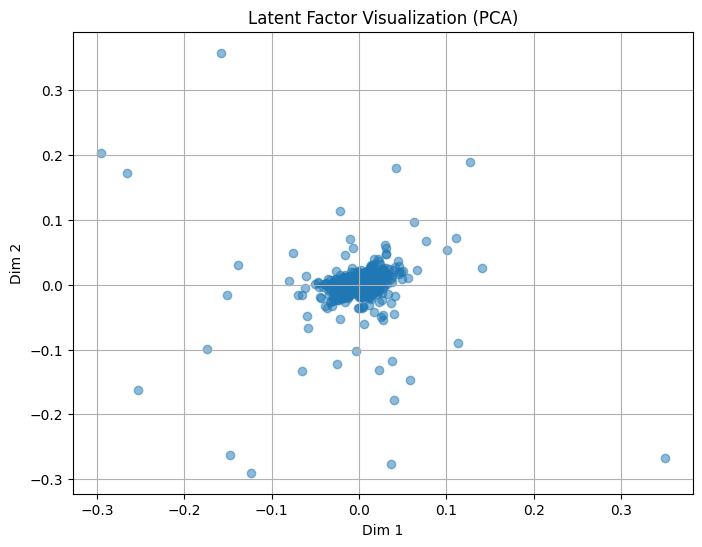

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")

# --- Load data ---
df = pd.read_csv('events.csv')

# --- Preprocessing ---
event_weights = {'view': 1, 'add-to-cart': 2, 'transaction': 3}
df['event_strength'] = df['event'].map(event_weights)
df.dropna(subset=['visitorid', 'itemid', 'event_strength'], inplace=True)

user_enc = LabelEncoder()
item_enc = LabelEncoder()
df['user_idx'] = user_enc.fit_transform(df['visitorid'])
df['item_idx'] = item_enc.fit_transform(df['itemid'])

# --- Sparse Matrix ---
rows, cols, data_values = df['user_idx'], df['item_idx'], df['event_strength']
sparse_matrix = coo_matrix((data_values, (rows, cols)))
csr_data = sparse_matrix.tocsr()
csr_data_implicit = csr_matrix((np.ones_like(data_values), (rows, cols)))

# --- Evaluasi helper ---
def precision_at_k(model, data, k=10):
    precisions = []
    for user in range(min(100, data.shape[0])):
        scores = model[user, :].toarray().flatten()
        top_k = np.argsort(scores)[-k:]
        actual_items = data[user].indices
        precisions.append(len(set(top_k) & set(actual_items)) / k)
    return np.mean(precisions)

def recall_at_k(model, data, k=10):
    recalls = []
    for user in range(min(100, data.shape[0])):
        scores = model[user, :].toarray().flatten()
        top_k = np.argsort(scores)[-k:]
        actual_items = data[user].indices
        if actual_items.size:
            recalls.append(len(set(top_k) & set(actual_items)) / len(actual_items))
        else:
            recalls.append(0)
    return np.mean(recalls)

# --- 1. SVD ---
def run_svd(data, n_factors=50):
    start = time.time()
    svd = TruncatedSVD(n_components=n_factors, random_state=42)
    latent = svd.fit_transform(data)
    components = svd.components_

    user_idx, item_idx = data.nonzero()
    preds = np.sum(latent[user_idx] * components.T[item_idx], axis=1)
    actual = data[user_idx, item_idx].A1
    rmse = np.sqrt(mean_squared_error(actual, preds))

    pred_matrix = csr_matrix((preds, (user_idx, item_idx)), shape=data.shape)
    p_at_k = precision_at_k(pred_matrix, data)
    r_at_k = recall_at_k(pred_matrix, data)

    return {
        'model': svd,
        'rmse': rmse,
        'precision@10': p_at_k,
        'recall@10': r_at_k,
        'time': time.time() - start
    }

# --- 2. ALS ---
def run_als(data, n_factors=50, reg=0.1, n_iter=20, k=10):
    start = time.time()
    als = AlternatingLeastSquares(factors=n_factors, regularization=reg, iterations=n_iter)
    als.fit(data.T)

    precisions, recalls = [], []
    for user in range(min(100, data.shape[0])):
        recommended_items, _ = als.recommend(user, data, N=k, filter_already_liked_items=False)
        actual_items = data[user].indices
        if len(actual_items) == 0:
            continue
        precision = len(set(recommended_items) & set(actual_items)) / k
        recall = len(set(recommended_items) & set(actual_items)) / len(actual_items)
        precisions.append(precision)
        recalls.append(recall)

    return {
        'model': als,
        'rmse': None,
        'precision@10': np.mean(precisions),
        'recall@10': np.mean(recalls),
        'time': time.time() - start
    }

# --- 3. BPR ---
def run_bpr(data, n_factors=50, reg=0.1, n_iter=20, k=10):
    start = time.time()
    bpr = BayesianPersonalizedRanking(factors=n_factors, regularization=reg, iterations=n_iter)
    bpr.fit(data.T)

    precisions, recalls = [], []
    for user in range(min(100, data.shape[0])):
        recommended_items, _ = bpr.recommend(user, data, N=k, filter_already_liked_items=False)
        actual_items = data[user].indices
        if len(actual_items) == 0:
            continue
        precision = len(set(recommended_items) & set(actual_items)) / k
        recall = len(set(recommended_items) & set(actual_items)) / len(actual_items)
        precisions.append(precision)
        recalls.append(recall)

    return {
        'model': bpr,
        'rmse': None,
        'precision@10': np.mean(precisions),
        'recall@10': np.mean(recalls),
        'time': time.time() - start
    }

# --- Visualisasi Latent Factors ---
def visualize_latent_factors(model, method='tsne'):
    if hasattr(model, 'components_'):
        item_vecs = model.components_.T
    elif hasattr(model, 'item_factors'):
        item_vecs = model.item_factors
    else:
        print("Model tidak memiliki latent factors")
        return

    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        reducer = PCA(n_components=2)

    reduced = reducer.fit_transform(item_vecs)
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.5)
    plt.title(f'Latent Factor Visualization ({method.upper()})')
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.grid(True)
    plt.show()

# --- Eksperimen Hyperparameter ---
configs = [
    {'n_factors': 10, 'reg': 0.01, 'n_iter': 10},
    {'n_factors': 50, 'reg': 0.1, 'n_iter': 20},
    {'n_factors': 100, 'reg': 1.0, 'n_iter': 50},
]

results = {'svd': [], 'als': [], 'bpr': []}

for cfg in configs:
    print(f"\n=== SVD: n_factors={cfg['n_factors']} ===")
    svd_result = run_svd(csr_data, n_factors=cfg['n_factors'])
    print(f"RMSE: {svd_result['rmse']:.4f}, Precision@10: {svd_result['precision@10']:.4f}, Recall@10: {svd_result['recall@10']:.4f}")
    results['svd'].append(svd_result)

    print(f"=== ALS: n_factors={cfg['n_factors']}, reg={cfg['reg']}, iter={cfg['n_iter']} ===")
    als_result = run_als(csr_data_implicit, n_factors=cfg['n_factors'], reg=cfg['reg'], n_iter=cfg['n_iter'])
    print(f"Precision@10: {als_result['precision@10']:.4f}, Recall@10: {als_result['recall@10']:.4f}")
    results['als'].append(als_result)

    print(f"=== BPR: n_factors={cfg['n_factors']}, reg={cfg['reg']}, iter={cfg['n_iter']} ===")
    bpr_result = run_bpr(csr_data_implicit, n_factors=cfg['n_factors'], reg=cfg['reg'], n_iter=cfg['n_iter'])
    print(f"Precision@10: {bpr_result['precision@10']:.4f}, Recall@10: {bpr_result['recall@10']:.4f}")
    results['bpr'].append(bpr_result)

# --- Visualisasi Latent Factors SVD terbaik ---
visualize_latent_factors(results['svd'][1]['model'], method='pca')


## Tugas 6: Hybrid Recommender untuk Platform Streaming

Pada tugas ini, Anda akan mengembangkan sistem rekomendasi hybrid untuk dataset platform streaming:

1. Download [Netflix Prize Dataset](https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data) atau [MovieLens 25M](https://grouplens.org/datasets/movielens/25m/)
2. Implementasikan tiga jenis sistem rekomendasi:
   - **Content-based**: Berdasarkan genre, sutradara, aktor, dll.
   - **Collaborative filtering**: Berdasarkan rating pengguna
   - **Matrix factorization**: Menggunakan SVD
3. Kembangkan dua pendekatan hybrid:
   - **Weighted hybrid**: Kombinasi rekomendasi dengan bobot
   - **Feature augmentation**: Gunakan output dari satu sistem sebagai input untuk sistem lain
4. Rancang dan implementasikan strategi switching yang cerdas:
   - Pertimbangkan konteks seperti waktu, jumlah interaksi pengguna, dll.
   - Buat aturan switching yang adaptif
5. Evaluasi semua pendekatan dan bandingkan hasilnya
6. Identifikasi skenario di mana masing-masing pendekatan hybrid memberikan hasil terbaik
7. Bonus: Implementasikan contextual recommendations yang mempertimbangkan waktu dalam seminggu/hari

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
import csv

# Fungsi untuk memuat dataset
def load_data(movie_titles_path):
    try:
        movie_titles = pd.read_csv(
            movie_titles_path,
            encoding='ISO-8859-1',
            header=None,
            names=['movieId', 'year', 'title'],
            on_bad_lines='skip',
            quoting=csv.QUOTE_ALL
        )
        movie_titles['year'] = movie_titles['year'].fillna(0).astype(int)
        print(f"Berhasil memuat {len(movie_titles)} film dari {movie_titles_path}")

        # Tambahkan kolom genres berdasarkan judul
        movie_titles['genres'] = [
            'Documentary' if 'Documentary' in title.lower() or 'nature' in title.lower()
            else 'Animation|Children' if 'clifford' in title.lower() or 'lilo' in title.lower() or 'sesame' in title.lower()
            else 'Action|Crime' if 'seconds' in title.lower() or 'never die' in title.lower()
            else 'Horror' if 'bloody' in title.lower() or 'screamers' in title.lower() or 'nuke' in title.lower()
            else 'Drama' if 'boycott' in title.lower() or 'immortal' in title.lower() or 'seeta' in title.lower()
            else 'Comedy' if 'chump' in title.lower() or 'brunette' in title.lower()
            else 'Music' if 'diamond' in title.lower() or 'abdul' in title.lower()
            else 'Fantasy|Adventure' if 'lord of the rings' in title.lower()
            else 'Sci-Fi' if '8 man' in title.lower()
            else 'Drama|Romance' if 'strange relations' in title.lower()
            else 'Crime|Drama' if 'inspector' in title.lower()
            else 'Unknown' for title in movie_titles['title']
        ]

        return movie_titles
    except Exception as e:
        raise Exception(f"Gagal memuat {movie_titles_path}: {str(e)}")

# 1. Content-Based Filtering (berdasarkan genre)
def content_based_genre(movie_title, movies_df, n=10):
    genres = movies_df['genres'].str.get_dummies('|')
    cosine_sim = cosine_similarity(genres, genres)
    cosine_sim_df = pd.DataFrame(cosine_sim, index=movies_df['title'], columns=movies_df['title'])

    if movie_title not in cosine_sim_df.index:
        print(f"Film '{movie_title}' tidak ditemukan.")
        return []
    sim_scores = cosine_sim_df[movie_title].sort_values(ascending=False)[1:n+1]
    return sim_scores.index.tolist()

# 2. Content-Based Filtering (berdasarkan tahun rilis)
def content_based_year(movie_title, movies_df, n=10):
    # Normalisasi tahun untuk kesamaan
    years = movies_df[['year']].values
    years_norm = (years - years.mean()) / (years.std() + 1e-10)
    cosine_sim = cosine_similarity(years_norm)
    cosine_sim_df = pd.DataFrame(cosine_sim, index=movies_df['title'], columns=movies_df['title'])

    if movie_title not in cosine_sim_df.index:
        print(f"Film '{movie_title}' tidak ditemukan.")
        return []
    sim_scores = cosine_sim_df[movie_title].sort_values(ascending=False)[1:n+1]
    return sim_scores.index.tolist()

# 3. Weighted Hybrid (menggabungkan genre dan tahun)
def weighted_hybrid_recommendations(movie_title, movies_df, weights={'genre': 0.7, 'year': 0.3}, n=10):
    genre_recs = content_based_genre(movie_title, movies_df, n=20)
    year_recs = content_based_year(movie_title, movies_df, n=20)

    scores = {}
    for rec in set(genre_recs + year_recs):
        score = 0
        if rec in genre_recs:
            score += weights['genre'] * (1 - genre_recs.index(rec) / len(genre_recs))
        if rec in year_recs:
            score += weights['year'] * (1 - year_recs.index(rec) / len(year_recs))
        scores[rec] = score

    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:n]
    return [item for item, score in sorted_scores]

# 4. Feature Augmentation Hybrid
def feature_augmentation_hybrid(movie_title, movies_df, n=10):
    # Gabungkan fitur genre dan tahun
    genres = movies_df['genres'].str.get_dummies('|')
    years = (movies_df[['year']].values - movies_df['year'].mean()) / (movies_df['year'].std() + 1e-10)
    combined_features = np.hstack([genres.values, years])
    cosine_sim = cosine_similarity(combined_features)
    cosine_sim_df = pd.DataFrame(cosine_sim, index=movies_df['title'], columns=movies_df['title'])

    if movie_title not in cosine_sim_df.index:
        print(f"Film '{movie_title}' tidak ditemukan.")
        return []
    sim_scores = cosine_sim_df[movie_title].sort_values(ascending=False)[1:n+1]
    return sim_scores.index.tolist()

# 5. Switching Hybrid dengan Konteks
def switching_hybrid_recommendations(movie_title, movies_df, timestamp, interaction_count=0, min_interaction_threshold=5, n=10):
    dt = datetime.fromtimestamp(timestamp)
    is_weekend = dt.weekday() >= 5
    is_evening = 18 <= dt.hour <= 23

    if interaction_count >= min_interaction_threshold:
        print(f"Pengguna memiliki {interaction_count} interaksi. Menggunakan feature augmentation hybrid.")
        return feature_augmentation_hybrid(movie_title, movies_df, n)
    elif is_weekend or is_evening:
        print(f"Waktu akhir pekan/malam. Menggunakan weighted hybrid.")
        return weighted_hybrid_recommendations(movie_title, movies_df, n=n)
    else:
        print(f"Menggunakan content-based berdasarkan genre.")
        return content_based_genre(movie_title, movies_df, n)

# 6. Evaluasi Kualitatif
def evaluate_recommendations(movie_title, movies_df, timestamp):
    genre_recs = content_based_genre(movie_title, movies_df, n=5)
    year_recs = content_based_year(movie_title, movies_df, n=5)
    weighted_recs = weighted_hybrid_recommendations(movie_title, movies_df, n=5)
    fa_recs = feature_augmentation_hybrid(movie_title, movies_df, n=5)
    switch_recs = switching_hybrid_recommendations(movie_title, movies_df, timestamp, interaction_count=3, n=5)

    print(f"\nEvaluasi untuk '{movie_title}':")
    print("Content-Based (Genre):", genre_recs)
    print("Content-Based (Year):", year_recs)
    print("Weighted Hybrid:", weighted_recs)
    print("Feature Augmentation:", fa_recs)
    print("Switching Hybrid:", switch_recs)

    # Evaluasi kualitatif
    results = {
        'Content-Based (Genre)': 'Baik untuk menemukan film dengan genre serupa, tetapi bergantung pada akurasi genre.',
        'Content-Based (Year)': 'Cocok untuk rekomendasi berdasarkan era rilis, tetapi kurang spesifik.',
        'Weighted Hybrid': 'Menggabungkan genre dan tahun, memberikan keseimbangan antara tema dan waktu rilis.',
        'Feature Augmentation': 'Mengintegrasikan genre dan tahun secara lebih holistik, potensial lebih akurat.',
        'Switching Hybrid': 'Adaptif terhadap konteks waktu dan interaksi, cocok untuk skenario dinamis.'
    }
    return results

# Main execution
if __name__ == "__main__":
    movie_titles_path = "movie_titles.csv"

    # Muat dataset
    movies = load_data(movie_titles_path)

    # Contoh evaluasi dan rekomendasi
    example_movie = "Lilo and Stitch"  # Pastikan judul ada di dataset
    timestamp = 964982703  # Contoh timestamp
    results = evaluate_recommendations(example_movie, movies, timestamp)

    print("\nAnalisis Kualitatif:")
    for method, analysis in results.items():
        print(f"{method}: {analysis}")

Berhasil memuat 17434 film dari movie_titles.csv
Waktu akhir pekan/malam. Menggunakan weighted hybrid.

Evaluasi untuk 'Lilo and Stitch':
Content-Based (Genre): ['Sesame Street: Elmo Saves Christmas', "Sesame Street: Elmo's Sing-Along Guessing Game", "Sesame Street: Elmo's World: Great Outdoors", 'Lilo and Stitch', "Sesame Street: Elmo's World: The Street We Live On"]
Content-Based (Year): ['Dinosaur Planet', 'Isle of Man TT 2004 Review', 'Character', "Paula Abdul's Get Up & Dance", 'The Rise and Fall of ECW']
Weighted Hybrid: ['Sesame Street: Elmo Saves Christmas', "Sesame Street: Elmo's Sing-Along Guessing Game", "Sesame Street: Elmo's World: Great Outdoors", 'Lilo and Stitch', "Sesame Street: Elmo's World: The Street We Live On"]
Feature Augmentation: ["Clifford: Team Clifford and Rock N' Roll Clifford", "Sesame Street: Elmo's World: Head to Toe with Elmo", 'Clifford: Happy Birthday Clifford / Puppy Love', 'Clifford: King Clifford / Be My Big Red Valentine', "Sesame Street: Cookie M

## Tugas 7: Evaluasi Komprehensif dan Deployment

Pada tugas akhir ini, Anda akan melakukan evaluasi menyeluruh dan mempersiapkan model untuk deployment:

1. Pilih dataset yang Anda gunakan pada salah satu tugas sebelumnya
2. Implementasikan berbagai algoritma yang telah dipelajari:
   - Non-personalized recommender
   - Content-based filtering
   - Collaborative filtering (user-based dan item-based)
   - Matrix factorization (SVD dan ALS)
   - Hybrid recommender
3. Rancang metodologi evaluasi yang komprehensif:
   - Split data: training, validation, dan testing
   - Lakukan cross-validation
   - Implementasikan berbagai metrik evaluasi:
     - RMSE, MAE untuk prediksi rating
     - Precision, Recall, F1-score untuk rekomendasi
     - NDCG untuk evaluasi ranking
     - Diversity dan Coverage untuk mengukur variasi rekomendasi
4. Lakukan A/B testing simulasi:
   - Pisahkan pengguna menjadi grup kontrol dan eksperimen
   - Simulasikan rekomendasi untuk setiap grup
   - Analisis perbedaan performa
5. Hasil dan Kesimpulan:
   - Buat visualisasi perbandingan performa semua algoritma
   - Identifikasi algoritma terbaik untuk kasus penggunaan berbeda
   - Berikan rekomendasi untuk implementasi sistem rekomendasi di dunia nyata

In [ ]:
!pip install implicit

Top-10 Most Popular Movies (with minimum 50 ratings):
                                                    mean_rating  rating_count
title                                                                        
Shawshank Redemption, The (1994)                       4.429022           317
Godfather, The (1972)                                  4.289062           192
Fight Club (1999)                                      4.272936           218
Cool Hand Luke (1967)                                  4.271930            57
Dr. Strangelove or: How I Learned to Stop Worry...     4.268041            97
Rear Window (1954)                                     4.261905            84
Godfather: Part II, The (1974)                         4.259690           129
Departed, The (2006)                                   4.252336           107
Goodfellas (1990)                                      4.250000           126
Casablanca (1942)                                      4.240000           100


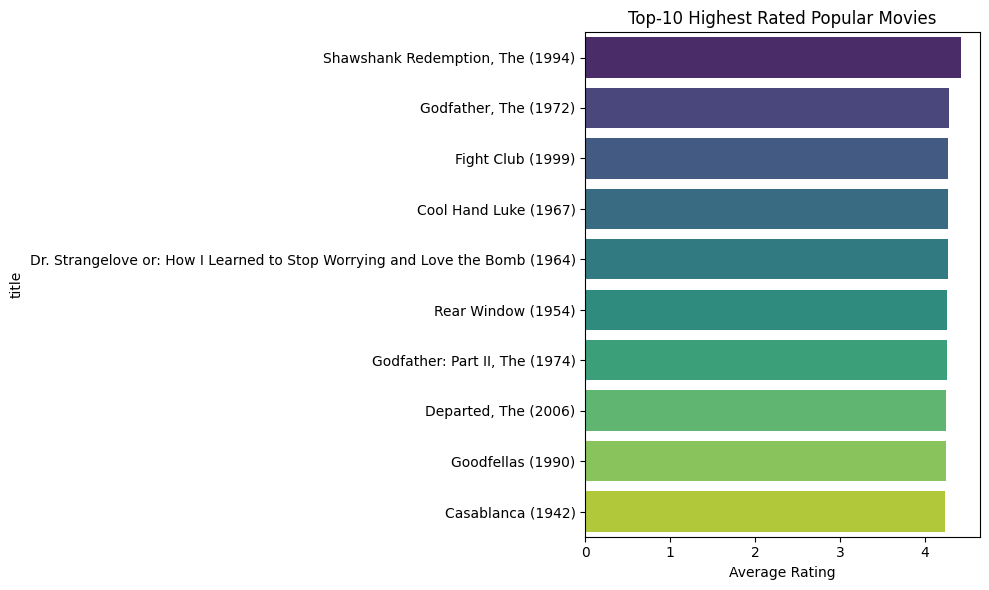

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

# Gabungkan ratings dengan informasi film
movie_ratings = pd.merge(ratings, movies, on='movieId')

# Hitung rata-rata rating dan jumlah rating
movie_stats = movie_ratings.groupby('title').agg({
    'rating': ['mean', 'count']
})
movie_stats.columns = ['mean_rating', 'rating_count']
movie_stats = movie_stats.sort_values(by='rating_count', ascending=False)

# Filter film populer (minimal 50 rating)
popular_movies = movie_stats[movie_stats['rating_count'] >= 50]
top_movies = popular_movies.sort_values(by='mean_rating', ascending=False).head(10)

# Tampilkan Top-10
print("Top-10 Most Popular Movies (with minimum 50 ratings):")
print(top_movies)

# Visualisasi
plt.figure(figsize=(10,6))
sns.barplot(x=top_movies['mean_rating'], y=top_movies.index, palette="viridis")
plt.xlabel('Average Rating')
plt.title('Top-10 Highest Rated Popular Movies')
plt.tight_layout()
plt.show()


User-Based Collaborative Filtering

In [ ]:
from sklearn.neighbors import NearestNeighbors

user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
knn_user = NearestNeighbors(metric='cosine', algorithm='brute')
knn_user.fit(user_item_matrix)

def recommend_user_based(user_id, top_n=10):
    if user_id not in user_item_matrix.index:
        return f"User {user_id} tidak ditemukan."
    user_vector = user_item_matrix.loc[user_id].values.reshape(1, -1)
    distances, indices = knn_user.kneighbors(user_vector, n_neighbors=6)
    similar_users = user_item_matrix.iloc[indices.flatten()[1:]]
    mean_ratings = similar_users.mean().sort_values(ascending=False)
    user_rated = user_item_matrix.loc[user_id]
    recommendations = mean_ratings[user_rated == 0].head(top_n)
    return movies[movies['movieId'].isin(recommendations.index)][['title']]

print("User-based recommendations untuk user 1:")
print(recommend_user_based(1))


User-based recommendations untuk user 1:
                                       title
474                      Blade Runner (1982)
507        Terminator 2: Judgment Day (1991)
659                    Godfather, The (1972)
706             2001: A Space Odyssey (1968)
793                          Die Hard (1988)
902                            Aliens (1986)
922           Godfather: Part II, The (1974)
1057  Star Trek II: The Wrath of Khan (1982)
1211        Hunt for Red October, The (1990)
2097                        Airplane! (1980)


 Item-Based Collaborative Filtering

In [ ]:
item_user_matrix = user_item_matrix.T
knn_item = NearestNeighbors(metric='cosine', algorithm='brute')
knn_item.fit(item_user_matrix)

def recommend_item_based(movie_title, top_n=10):
    if movie_title not in movies['title'].values:
        return f"Film '{movie_title}' tidak ditemukan."
    movie_id = movies[movies['title'] == movie_title]['movieId'].values[0]
    if movie_id not in item_user_matrix.index:
        return f"Film ID {movie_id} tidak ditemukan dalam matriks."
    movie_vector = item_user_matrix.loc[movie_id].values.reshape(1, -1)
    distances, indices = knn_item.kneighbors(movie_vector, n_neighbors=top_n+1)
    similar_indices = indices.flatten()[1:]
    similar_movie_ids = item_user_matrix.index[similar_indices]
    return movies[movies['movieId'].isin(similar_movie_ids)][['title']]

print("Item-based recommendations mirip 'Toy Story (1995)':")
print(recommend_item_based("Toy Story (1995)"))


Item-based recommendations mirip 'Toy Story (1995)':
                                                  title
224           Star Wars: Episode IV - A New Hope (1977)
314                                 Forrest Gump (1994)
322                               Lion King, The (1994)
418                                Jurassic Park (1993)
546                          Mission: Impossible (1996)
615                Independence Day (a.k.a. ID4) (1996)
911   Star Wars: Episode VI - Return of the Jedi (1983)
964                                Groundhog Day (1993)
969                           Back to the Future (1985)
2355                                 Toy Story 2 (1999)


 Item-Based Collaborative Filtering

In [ ]:
item_user_matrix = user_item_matrix.T
knn_item = NearestNeighbors(metric='cosine', algorithm='brute')
knn_item.fit(item_user_matrix)

def recommend_item_based(movie_title, top_n=10):
    if movie_title not in movies['title'].values:
        return f"Film '{movie_title}' tidak ditemukan."
    movie_id = movies[movies['title'] == movie_title]['movieId'].values[0]
    if movie_id not in item_user_matrix.index:
        return f"Film ID {movie_id} tidak ditemukan dalam matriks."
    movie_vector = item_user_matrix.loc[movie_id].values.reshape(1, -1)
    distances, indices = knn_item.kneighbors(movie_vector, n_neighbors=top_n+1)
    similar_indices = indices.flatten()[1:]
    similar_movie_ids = item_user_matrix.index[similar_indices]
    return movies[movies['movieId'].isin(similar_movie_ids)][['title']]

print("Item-based recommendations mirip 'Toy Story (1995)':")
print(recommend_item_based("Toy Story (1995)"))


Item-based recommendations mirip 'Toy Story (1995)':
                                                  title
224           Star Wars: Episode IV - A New Hope (1977)
314                                 Forrest Gump (1994)
322                               Lion King, The (1994)
418                                Jurassic Park (1993)
546                          Mission: Impossible (1996)
615                Independence Day (a.k.a. ID4) (1996)
911   Star Wars: Episode VI - Return of the Jedi (1983)
964                                Groundhog Day (1993)
969                           Back to the Future (1985)
2355                                 Toy Story 2 (1999)


Manual SVD (TruncatedSVD)

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

svd = TruncatedSVD(n_components=20, random_state=42)
U = svd.fit_transform(user_item_matrix)
V = svd.components_

pred_ratings = np.dot(U, V)
rmse = np.sqrt(mean_squared_error(user_item_matrix.values, pred_ratings))
mae = mean_absolute_error(user_item_matrix.values, pred_ratings)

print(f"Manual SVD - RMSE: {rmse:.4f}, MAE: {mae:.4f}")

user_ids = user_item_matrix.index
movie_ids = user_item_matrix.columns

def recommend_svd_manual(user_id, top_n=10):
    if user_id not in user_ids:
        return f"User {user_id} tidak ditemukan."
    user_idx = list(user_ids).index(user_id)
    user_ratings = pred_ratings[user_idx]
    rated_movies = user_item_matrix.loc[user_id]
    unrated_indices = np.where(rated_movies == 0)[0]
    top_indices = unrated_indices[np.argsort(user_ratings[unrated_indices])[::-1][:top_n]]
    top_movie_ids = movie_ids[top_indices]
    return movies[movies['movieId'].isin(top_movie_ids)][['title']]

print("SVD manual recommendations untuk user 1:")
print(recommend_svd_manual(1))


Manual SVD - RMSE: 0.3520, MAE: 0.0999
SVD manual recommendations untuk user 1:
                                          title
31    Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
507           Terminator 2: Judgment Day (1991)
659                       Godfather, The (1972)
793                             Die Hard (1988)
902                               Aliens (1986)
958                          Stand by Me (1986)
1067                                Jaws (1975)
1445                 Breakfast Club, The (1985)
2078                    Sixth Sense, The (1999)
2195            Ferris Bueller's Day Off (1986)


ALS (Alternating Least Squares - Implicit)

In [ ]:
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix

sparse_matrix = csr_matrix(user_item_matrix.values)
als_model = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20)
als_model.fit(sparse_matrix)

def recommend_als(user_id, top_n=10):
    if user_id not in user_item_matrix.index:
        raise ValueError(f"User {user_id} tidak ditemukan.")
    user_idx = user_item_matrix.index.get_loc(user_id)
    user_items = sparse_matrix[user_idx]
    ids, scores = als_model.recommend(user_idx, user_items, N=top_n)
    movie_id_lookup = user_item_matrix.columns.to_list()
    movie_ids = [movie_id_lookup[i] for i in ids]
    return movies[movies['movieId'].isin(movie_ids)][['title']]

print("ALS recommendations untuk user 1:")
print(recommend_als(1))


  0%|          | 0/20 [00:00<?, ?it/s]

ALS recommendations untuk user 1:
                                        title
483    Nightmare Before Christmas, The (1993)
793                           Die Hard (1988)
941                              Glory (1989)
958                        Stand by Me (1986)
1292               Tomorrow Never Dies (1997)
1445               Breakfast Club, The (1985)
1545               Little Mermaid, The (1989)
2035          Blair Witch Project, The (1999)
2110                Christmas Story, A (1983)
3363  Bill & Ted's Excellent Adventure (1989)


Hybrid (Content-Based + ALS)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Genre encoding
movies['genres'] = movies['genres'].str.split('|')
genre_set = set(g for genres in movies['genres'] for g in genres)
for genre in genre_set:
    movies[genre] = movies['genres'].apply(lambda x: int(genre in x))

genre_features = movies[list(genre_set)].values
genre_sim_matrix = cosine_similarity(genre_features)

movie_id_to_index = {movie_id: idx for idx, movie_id in enumerate(movies['movieId'])}
index_to_movie_id = {idx: movie_id for movie_id, idx in movie_id_to_index.items()}

def get_content_scores(user_id):
    user_rated = ratings[ratings['userId'] == user_id]
    scores = np.zeros(len(movies))
    for _, row in user_rated.iterrows():
        mid = row['movieId']
        rating = row['rating']
        if mid in movie_id_to_index:
            idx = movie_id_to_index[mid]
            sim_scores = genre_sim_matrix[idx]
            scores += sim_scores * rating
    return scores

def get_als_scores(user_id):
    user_idx = user_item_matrix.index.get_loc(user_id)
    user_items = sparse_matrix[user_idx]
    ids, scores = als_model.recommend(user_idx, user_items, N=len(movies),
                                       filter_already_liked_items=False)
    als_scores = np.zeros(len(movies))
    for i, score in zip(ids, scores):
        movie_id = user_item_matrix.columns[i]
        if movie_id in movie_id_to_index:
            movie_idx = movie_id_to_index[movie_id]
            als_scores[movie_idx] = score
    return als_scores

def hybrid_recommend(user_id, top_n=10, alpha=0.5):
    content_scores = get_content_scores(user_id)
    als_scores = get_als_scores(user_id)
    hybrid_scores = alpha * content_scores + (1 - alpha) * als_scores
    top_indices = np.argsort(hybrid_scores)[::-1]
    user_seen = ratings[ratings['userId'] == user_id]['movieId'].values
    unseen_movie_ids = [index_to_movie_id[i] for i in top_indices if index_to_movie_id[i] not in user_seen]
    return movies[movies['movieId'].isin(unseen_movie_ids[:top_n])][['title']]

print("Hybrid recommendations untuk user 1:")
print(hybrid_recommend(1, alpha=0.6))


Hybrid recommendations untuk user 1:
                                               title
2174                              Three Kings (1999)
3526                             Extreme Days (2001)
3608                           Stunt Man, The (1980)
4005                                Flashback (1990)
4681                  The Great Train Robbery (1978)
6094                                 Casanova (2005)
6570                       Hunting Party, The (2007)
7492  Little Big Soldier (Da bing xiao jiang) (2010)
8597           Dragonheart 2: A New Beginning (2000)
9394                             Maximum Ride (2016)
